In [1]:
import sys, os
import cv2
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from inversion_attacks import GradientInversion_Attack
#import aijack.attack.inversion.hybrid_util as hybrid
#from aijack.utils import NumpyDataset, construct_dataloaders, consts, psnr, ConservativeStrategy
from vit_pytorch import ViT


import numpy as np
from PIL import Image

from IQA_pytorch import SSIM 
import lpips 
import csv 

In [2]:
class LeNet(nn.Module):
        def __init__(self, channel=3, hideen=768, num_classes=10):
            super(LeNet, self).__init__()
            act = nn.Sigmoid
            self.body = nn.Sequential(
                nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
                nn.BatchNorm2d(12),
                act(),
                nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
                nn.BatchNorm2d(12),
                act(),
                nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
                nn.BatchNorm2d(12),
                act(),
            )
            self.fc = nn.Sequential(nn.Linear(hideen, num_classes))

        def forward(self, x):
            out = self.body(x)
            out = out.view(out.size(0), -1)
            out = self.fc(out)
            return out

In [3]:
num_classes = 10
channel = 1
hidden = 588
seed = 42

device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
setup = dict(device=device, dtype=torch.float)  
print(setup)

{'device': device(type='cuda', index=0), 'dtype': torch.float32}


In [4]:
x = torch.load("./demodata/demo_mnist_x.pt").to(**setup)
y = torch.load("./demodata/demo_mnist_y.pt").to(device)

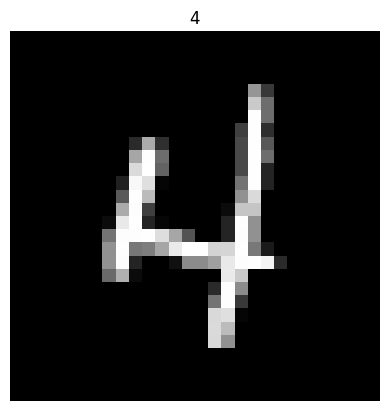

In [5]:
plt.imshow(x[0].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
plt.axis("off")
plt.title(y.item())
plt.show()

In [6]:
criterion = nn.CrossEntropyLoss()
net = LeNet(channel=channel, hideen=hidden, num_classes=num_classes).to(device)
pred = net(x)
loss = criterion(pred, y)
received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]

In [7]:
bn_reg_layers=[net.body[1], net.body[4], net.body[7]]
bn_reg_layers

[BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]

In [8]:
dlg_attacker_1 = GradientInversion_Attack(
    net, (1, 28, 28), lr=1.0, 
    log_interval=100, num_iteration=1200, distancename="l2",
    device=device )

In [9]:
dlg_attacker_1.reset_seed(seed)
reconstructed_x_1, reconstructed_y_1 = dlg_attacker_1.attack(received_gradients)


TypeError: min() received an invalid combination of arguments - got (Tensor, float), but expected one of:
 * (Tensor input)
 * (Tensor input, Tensor other, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, tuple of Tensors out)
 * (Tensor input, name dim, bool keepdim, *, tuple of Tensors out)


: 

In [ ]:
plt.imshow(reconstructed_x_1[0].permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
plt.axis("off")
plt.show()

: 

In [8]:
results_list = \
[[0, 0.046183813363313675, 1.019648790359497, 0.575711190700531, 5.936093807220459, 0.0018603120697662234, 0.9703517556190491, 'beagle'],
 [1, 0.046183813363313675, 1.019648790359497, 0.575711190700531, 5.936093807220459, 0.0018603120697662234, 0.9703517556190491, 'beagle']]
import numpy as np
temp = list(np.mean([r[1:-1] for r in results_list],axis=0))
temp.insert(0,'Averaged')
temp

['Averaged',
 0.046183813363313675,
 1.019648790359497,
 0.575711190700531,
 5.936093807220459,
 0.0018603120697662234,
 0.9703517556190491]

: 